In [25]:
import torch
import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input channel, 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 6 input channels, 6 output channels, 5x5 kernel
        self.pool1 = nn.MaxPool2d(2, 2)

        # 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 16 input channels, 16 output channels, 5x5 kernel
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)  # input shape: (batch_size, 1, 28, 28)
        x = torch.relu(x)  # output shape: (batch_size, 6, 24, 24)
        x = self.pool1(x)  # output shape: (batch_size, 6, 12, 12)

        x = self.conv2(x)  # input shape: (batch_size, 6, 12, 12)
        x = torch.relu(x)  # output shape: (batch_size, 16, 8, 8)
        x = self.pool2(x)  # output shape: (batch_size, 16, 4, 4)

        x = x.view(x.shape[0], -1)  # output shape: (batch_size, 16*4*4)
        x = self.fc1(x)  # output shape: (batch_size, 120)
        x = torch.relu(x)
        x = self.fc2(x)  # output shape: (batch_size, 84)
        x = torch.relu(x)
        x = self.fc3(x)  # output shape: (batch_size, 10)

        return x

    def predict(self, x):
        with torch.no_grad():
            output = self.forward(x)
            prob = torch.softmax(output, dim=1)
            prob_list = prob.squeeze().tolist()
            prob, index = torch.max(prob, 1)
        return index, prob, prob_list


def print_params(model):
    count = 0
    for name, param in model.named_parameters():
        count += param.numel()
        print(name, param.shape)
    print('total parameters:', count)


def print_forward(model, x):
    print('input x to model:', x.shape)
    for name, layer in model.named_children():
        if name == 'fc1':
            x = x.view(x.shape[0], -1)
        x = layer(x)
        print(f'{name} after size: {x.shape}')


test_model = LeNet()
print(test_model)
print('---')
print_params(test_model)

x = torch.randn(64, 1, 28, 28)
print_forward(test_model, x)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
---
conv1.weight torch.Size([6, 1, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 256])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])
total parameters: 44426
input x to model: torch.Size([64, 1, 28, 28])
conv1 after size: torch.Size([64, 6, 24, 24])
pool1 after size: torch.Size([64, 6, 12, 12])
conv2 after size: torch.Size([64, 16, 8, 

In [26]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random

# 设置全局随机种子
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)


transform = transforms.Compose([
    transforms.RandomRotation(12),  # 随机旋转 12 度
    transforms.ToTensor(),
])

# 加载训练数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)


# 定义训练数据加载器
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)

In [27]:
learning_rate = 0.001
model = LeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
# import wandb
# wandb.require("core")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)

epochs = 100
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        if (i + 1) % 100 == 0:
            # wandb.log({"loss": loss.item(), "acc": acc.item()})
            print(
                f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


# wandb.finish()

Epoch [1/100], Step [100/938], Loss: 0.6048
Epoch [1/100], Step [200/938], Loss: 0.4350
Epoch [1/100], Step [300/938], Loss: 0.2492
Epoch [1/100], Step [400/938], Loss: 0.2758
Epoch [1/100], Step [500/938], Loss: 0.1600
Epoch [1/100], Step [600/938], Loss: 0.1157
Epoch [1/100], Step [700/938], Loss: 0.2832
Epoch [1/100], Step [800/938], Loss: 0.0978
Epoch [1/100], Step [900/938], Loss: 0.1411
Epoch [2/100], Step [100/938], Loss: 0.0956
Epoch [2/100], Step [200/938], Loss: 0.0547
Epoch [2/100], Step [300/938], Loss: 0.0584
Epoch [2/100], Step [400/938], Loss: 0.1105
Epoch [2/100], Step [500/938], Loss: 0.0100
Epoch [2/100], Step [600/938], Loss: 0.0322
Epoch [2/100], Step [700/938], Loss: 0.0795
Epoch [2/100], Step [800/938], Loss: 0.0537
Epoch [2/100], Step [900/938], Loss: 0.0379
Epoch [3/100], Step [100/938], Loss: 0.1153
Epoch [3/100], Step [200/938], Loss: 0.0156
Epoch [3/100], Step [300/938], Loss: 0.1798
Epoch [3/100], Step [400/938], Loss: 0.0555
Epoch [3/100], Step [500/938], L

In [16]:
model = LeNet()
model.load_state_dict(torch.load(
    './model.pth', map_location=torch.device('cpu')))

/var/folders/4d/14nkpqsn4zs8c1dmkl0p4mxr0000gp/T/ipykernel_65232/703398484.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


<All keys matched successfully>

{0: 5, 1: 5, 2: 5, 3: 11, 4: 7, 5: 14, 6: 11, 7: 8, 8: 15, 9: 20}
error-count: 101
Accuracy of the network on the 10000 test images: 98.99%


<BarContainer object of 10 artists>

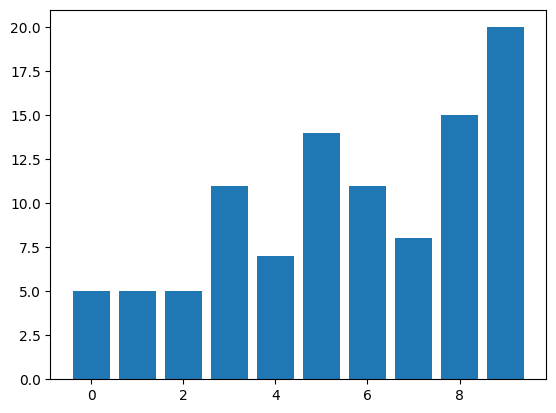

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

# 测试模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    """ 统计每个数字的错误次数 """
    error_count_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0
    }
    test_loss = 0.0
    correct = 0
    total = 0

    for batch_index, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        error_index = np.where((predicted == labels).cpu().numpy() == False)[0]
        for index in error_index:
            error_count_dict[labels[index].item()] += 1

test_loss /= total
test_accuracy = correct / total

pprint(error_count_dict)
print('error-count:', sum(error_count_dict.values()))
print('Accuracy of the network on the 10000 test images: {:.2f}%'.format(
    100 * test_accuracy))

# 将每个数字的错误次数绘制为柱状图
plt.bar(error_count_dict.keys(), error_count_dict.values())

In [15]:
# 保存后加载模型
torch.save(model.state_dict(), './model.pth')

# model = Net()
# model.load_state_dict(torch.load('./server/model.pth'))

# # 创建一个示例输入张量（假设输入尺寸是 [1, 784]）
# dummy_input = torch.randn(1, 28 * 28)

# # 导出模型到 ONNX 格式
# torch.onnx.export(
#     model,                # 要转换的模型
#     dummy_input,          # 示例输入张量
#     "model.onnx",         # 导出的 ONNX 文件名
#     input_names=['input'],  # 输入张量的名称
#     output_names=['output'],  # 输出张量的名称
#     opset_version=11      # ONNX opset 版本，通常使用最新版本（这里使用 11）
# )

In [22]:
for name, param in model.named_parameters():
    print(name, param.shape)
    print(param)

conv1.weight torch.Size([6, 1, 5, 5])
Parameter containing:
tensor([[[[-0.0835, -0.1147,  0.1766, -0.2374, -0.3184],
          [ 0.2185, -0.0712,  0.3234, -0.1315, -0.4185],
          [ 0.0095,  0.0825,  0.3548,  0.1549, -0.4919],
          [-0.1100,  0.1137,  0.3204,  0.2863,  0.1132],
          [-0.3496, -0.0276,  0.1008,  0.2028,  0.1251]]],


        [[[-0.0621,  0.1024, -0.4355, -0.3109, -0.3119],
          [-0.0978, -0.3006, -0.1599, -0.2412, -0.0855],
          [ 0.0588, -0.1527,  0.1515,  0.0362,  0.0635],
          [ 0.3056,  0.2454,  0.3532,  0.5081,  0.3636],
          [-0.0525,  0.1815, -0.0728, -0.1059,  0.0304]]],


        [[[ 0.0142,  0.1986,  0.1604,  0.4141,  0.1842],
          [ 0.0671,  0.0861,  0.2015,  0.1312,  0.5027],
          [-0.2690, -0.1346,  0.1009, -0.1540,  0.0628],
          [ 0.0016, -0.0773, -0.3285, -0.2970, -0.3599],
          [-0.1304, -0.0544, -0.2001, -0.1619, -0.1192]]],


        [[[ 0.1370,  0.3224,  0.1260,  0.0338, -0.1960],
          [ 0.30